# libs & pre processing

In [1]:
!pip install spacy
!pip install torchdata
!pip install torchtext

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df_clean = pd.read_csv('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/Combined_Data.csv')

In [4]:
df_clean

,Unnamed: 0,statement,label
0,0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0
1,1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0
2,2,Celebrities Join Tax March in Protest of Donal...,0
3,3,Cindy Crawford's daughter Kaia Gerber wears a ...,0
4,4,Full List of 2018 Oscar Nominations – Variety,0
...,...,...,...
28860,1275,"""I supported (the surge), I argued for it. I'm...",0
28861,1276,Says U.S. Rep. Charles Bass wants to privatize...,0
28862,1278,"In the past two years, Democrats have spent mo...",0
28863,1282,"""A new poll shows 62 percent support the presi...",0


In [5]:
df_clean=df_clean.drop(columns=['Unnamed: 0'])
df_clean

,statement,label
0,Did Miley Cyrus and Liam Hemsworth secretly ge...,0
1,Paris Jackson & Cara Delevingne Enjoy Night Ou...,0
2,Celebrities Join Tax March in Protest of Donal...,0
3,Cindy Crawford's daughter Kaia Gerber wears a ...,0
4,Full List of 2018 Oscar Nominations – Variety,0
...,...,...
28860,"""I supported (the surge), I argued for it. I'm...",0
28861,Says U.S. Rep. Charles Bass wants to privatize...,0
28862,"In the past two years, Democrats have spent mo...",0
28863,"""A new poll shows 62 percent support the presi...",0


In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_punctuations(word):
    stop_words = set(stopwords.words('english'))
    words = word.split()
    pattern=r'[^\w\s]'
    return re.sub(pattern,' ',word).lower()
def remove_stopwords(word):
    stop_words = set(stopwords.words('english'))
    words = word.split()
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df_clean['statement_modified']=df_clean['statement'].apply(remove_punctuations)
# df_clean['statement_modified']=df_clean['statement_modified'].apply(remove_stopwords)
df_clean['statement'] = df_clean['statement_modified']
df_clean=df_clean.drop(columns=['statement_modified'])

In [8]:
X=df_clean['statement']
y=df_clean['label']
print(X.head())
print(y.head())
data=list(zip(y,X))
print(data[0])

0    did miley cyrus and liam hemsworth secretly ge...
1    paris jackson   cara delevingne enjoy night ou...
2    celebrities join tax march in protest of donal...
3    cindy crawford s daughter kaia gerber wears a ...
4        full list of 2018 oscar nominations   variety
Name: statement, dtype: object
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64
(0, 'did miley cyrus and liam hemsworth secretly get married ')


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torchdata.datapipes as dp
from torch.utils.data import Dataset, DataLoader,random_split,TensorDataset

import spacy

In [10]:
vocab_size=15000
eng = spacy.load("en_core_web_sm")
def tokenizer(text):
    return [token.text for token in eng.tokenizer(text)]
def getTokens(data):
    for _,text in data:
        yield tokenizer(text)
source_vocab = build_vocab_from_iterator(
    getTokens(data),
    min_freq=0,
    specials= ['<pad>','<unk>'],
    special_first=True
)
source_vocab.set_default_index(source_vocab["<unk>"])

def getTransform(vocab):
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        # T.AddToken(1, begin=True),
        # ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # # 2 as seen in previous section
        # T.AddToken(2, begin=False)
    )
    return text_tranform

text_pipeline=lambda x:getTransform(source_vocab)(tokenizer(x))


In [11]:
max_len=-1
sen=""
for _,text in data:
    max_len=max(len(text_pipeline(text)),max_len)
    sen=text_pipeline(text)
print(max_len)

74


In [12]:
# device='cuda' if torch.cuda.is_available else 'cpu'
device='cpu'
class NewsData(Dataset):
    def __init__(self,text,label):
        self.text=text
        self.label=label
    def __len__(self):
        return len(self.label)

    def __getitem__(self,idx):
        text=self.text.iloc[idx]
        tokenized_text=text_pipeline(text).copy()
        for _ in range(max_len-len(tokenized_text)):
            tokenized_text.append(0)
        tokenized_text=torch.tensor(tokenized_text)
        label=torch.tensor(self.label.iloc[idx])
        return tokenized_text.to(device),label.to(device)

In [13]:
dataset=NewsData(X,y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train, val, test = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train, batch_size=50)
val_dataloader = DataLoader(val, batch_size=50)
test_dataloader = DataLoader(test, batch_size=50)

In [14]:
print(test_dataloader.__len__()*50)
index_to_string=source_vocab.get_itos()

2900


In [15]:
for data in val_dataloader:
    text,label=data
    sen=text[15]
    for i in sen:
        print(index_to_string[i],end=" ")
    print(label)
    break

margot robbie shares her one regret for taking on the role of harley quinn <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1])


In [16]:
for data in train_dataloader:
    text,label=data
    print(text.shape)
    print(label.shape)
    break

torch.Size([50, 74])
torch.Size([50])


# RESNET Model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3):
        super(ResidualBlock, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(input_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(hidden_dim, out_channels=output_dim, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential()
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(
                nn.Conv1d(input_dim, output_dim, kernel_size=1),
                nn.BatchNorm1d(output_dim)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Resnet2(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dims, num_classes):
        super(Resnet2, self).__init__()
        self.embd1 = nn.Embedding(vocab_size, embedding_size)
        self.conv1 = nn.Conv1d(embedding_size, hidden_dims[0], kernel_size=3, padding=1)

        self.rb1 = ResidualBlock(hidden_dims[0], hidden_dims[1], hidden_dims[1])
        self.rb2 = ResidualBlock(hidden_dims[1], hidden_dims[2], hidden_dims[2])
        self.rb3 = ResidualBlock(hidden_dims[2], hidden_dims[3], hidden_dims[3])

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dims[3], num_classes)

    def forward(self, x):
        x = x.to(torch.int)
        x = self.embd1(x)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.rb1(x)
        # print(x.shape)
        x = self.rb2(x)
        # print(x.shape)
        x = self.rb3(x)
        # print(x.shape)

        x = self.avgpool(x)
        # print(x.shape)
        x = x.squeeze(2)
        x = self.fc(x)
        # print(x.shape)

        return x

In [ ]:
vocab_size = 100000
embedding_dim = 74
hidden_dim = 37
num_classes = 1
model = Resnet1(vocab_size, embedding_dim, hidden_dim, num_classes)

In [25]:
vocab_size = 100000
embedding_dim = 74
hidden_dims = [128, 256, 512, 1024]
num_classes = 1
model = Resnet2(vocab_size, embedding_dim, hidden_dims, num_classes)

In [26]:
from torchsummary import summary
summary(model.cuda(),(50,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 50, 74]       7,400,000
            Conv1d-2              [-1, 128, 50]          28,544
            Conv1d-3              [-1, 256, 50]          33,024
       BatchNorm1d-4              [-1, 256, 50]             512
            Conv1d-5              [-1, 256, 50]          98,560
       BatchNorm1d-6              [-1, 256, 50]             512
              ReLU-7              [-1, 256, 50]               0
            Conv1d-8              [-1, 256, 50]         196,864
       BatchNorm1d-9              [-1, 256, 50]             512
             ReLU-10              [-1, 256, 50]               0
    ResidualBlock-11              [-1, 256, 50]               0
           Conv1d-12              [-1, 512, 50]         131,584
      BatchNorm1d-13              [-1, 512, 50]           1,024
           Conv1d-14              [-1, 

In [27]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 14326977


In [28]:
import torch.optim as optim
from torch.autograd import Variable


model = model.cuda()

los_values = []
acc_values = []

val_los_values = []
val_acc_values = []

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



for epoch in range(5):

    running_loss = 0.0
    running_corrects = 0.0
    count = 0
    print(len(train_dataloader))

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)

        # TODO: calculate the preds
        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)
        loss = criterion(outputs.float(), labels.float())

        if(i%100 == 0):
          print(i)
          print(loss)
        loss.backward()
        optimizer.step()



        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)
        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}, loss: {running_loss / count:.3f}')

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = (running_corrects / len(train_dataloader.dataset))*100
    print(f'Epoch {epoch + 1} completed. Training Loss: {epoch_loss:.3f}, Training Accuracy: {epoch_acc:.3f}')
    los_values.append(epoch_loss)
    acc_values.append(epoch_acc)

    running_loss = 0.0
    running_corrects = 0
    count = 0


    val_corrects = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())


            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()
            labels = labels.view(-1, 1)
            vloss = criterion(outputs.float(), labels.float())

            val_loss +=vloss.item()

            val_corrects += torch.sum(preds == labels.data)

    val_accuracy = (val_corrects / len(val_dataloader.dataset)) * 100
    ep_val_loss = val_loss/len(val_dataloader.dataset)

    print(f'Epoch {epoch + 1} completed. Validation Loss: {ep_val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')
    val_los_values.append(ep_val_loss)
    val_acc_values.append(val_accuracy)


462
0
tensor(0.6853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,    50] accuracy: 0.631, loss: 0.013
[1,   100] accuracy: 0.647, loss: 0.013
100
tensor(0.6317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   150] accuracy: 0.653, loss: 0.013
[1,   200] accuracy: 0.660, loss: 0.013
200
tensor(0.6319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   250] accuracy: 0.662, loss: 0.013
[1,   300] accuracy: 0.667, loss: 0.013
300
tensor(0.6207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   350] accuracy: 0.669, loss: 0.012
[1,   400] accuracy: 0.674, loss: 0.012
400
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   450] accuracy: 0.675, loss: 0.012
Epoch 1 completed. Training Loss: 0.012, Training Accuracy: 67.530
Epoch 1 completed. Validation Loss: 0.011, Validation Accuracy: 71.275
462
0
tensor(0.6533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[2,    50] accuracy: 0.700, loss: 0.012
[2,   10

In [29]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong
model.eval()
test_corrects = 0
test_total = 0

y_predl = []
y_truel = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)

        #print(preds)
        #print(labels.data)

        test_corrects += torch.sum(preds == labels.data)
        test_total += len(preds)

        y_predl.append(preds)
        y_truel.append(labels.data)


test_accuracy = (test_corrects / test_total) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 76.58%


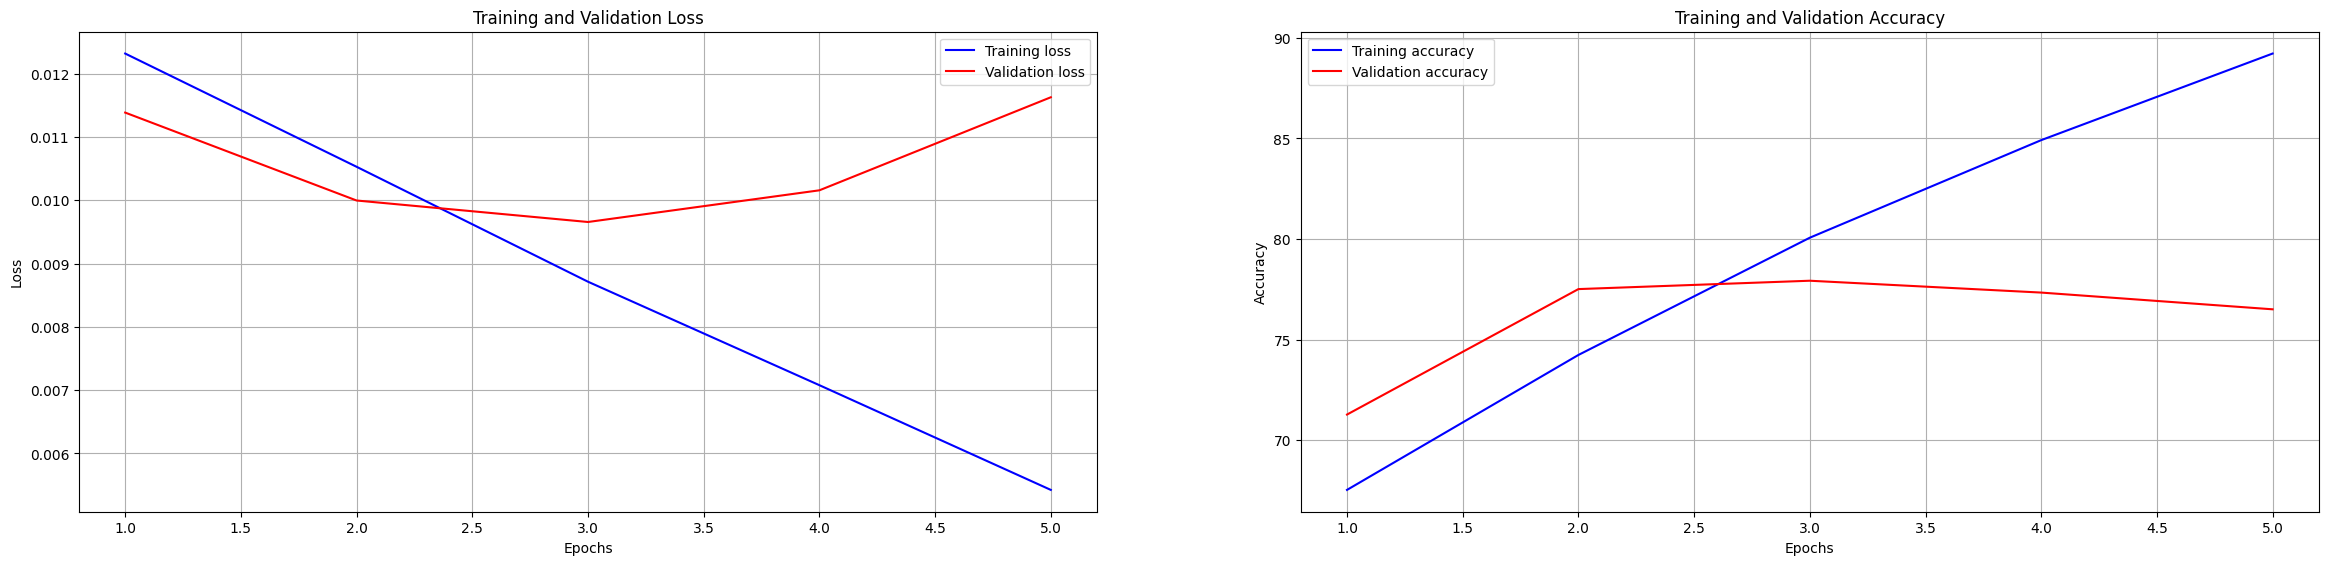

In [30]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, len(los_values) + 1)

acc_train= [tensor.item() for tensor in acc_values]
acc_val = [tensor.item() for tensor in val_acc_values]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(left=0.1, right=1.5, bottom=0.1, top=0.9)

axs[0].plot(epochs, los_values, 'b', label='Training loss')
axs[0].plot(epochs, val_los_values, 'r', label='Validation loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(epochs, acc_train, 'b', label='Training accuracy')
axs[1].plot(epochs, acc_val, 'r', label='Validation accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
y_pred = torch.cat(y_predl).cpu().numpy().flatten()
y_true = torch.cat(y_truel).cpu().numpy().flatten()

# Compute precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.7921
Recall: 0.8319
F1 Score: 0.8115
Confusion Matrix:
[[ 756  382]
 [ 294 1455]]


In [32]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.66, False Positive Rate: 0.17
Class 1 - Precision: 0.72, Recall: 0.66

Class 2 - True Positive Rate: 0.83, False Positive Rate: 0.34
Class 2 - Precision: 0.79, Recall: 0.83



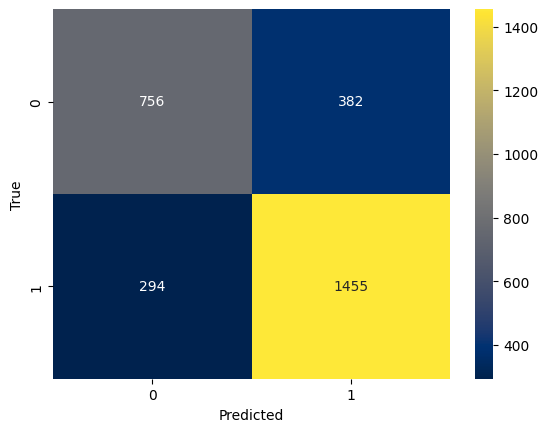

<Figure size 2000x1000 with 0 Axes>

In [33]:
import seaborn as sns
sns.heatmap(con_mat, annot=True, fmt='d', cmap='cividis', cbar=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()



0.7481136597262206


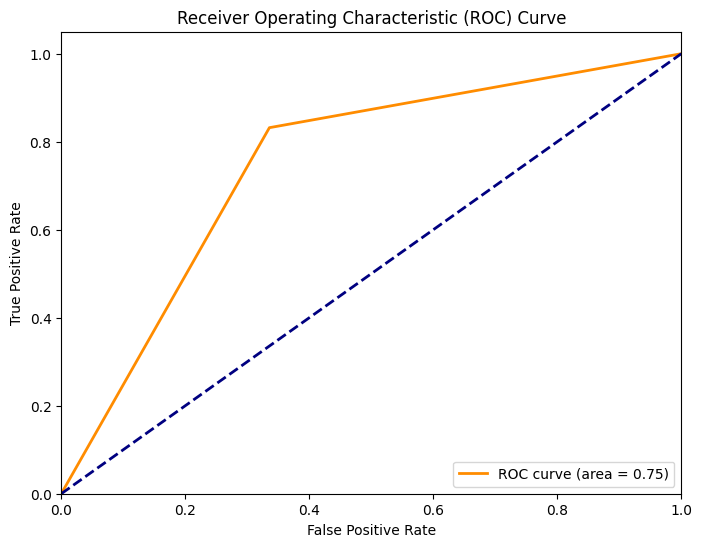

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
print(model)

Resnet2(
  (embd1): Embedding(100000, 74)
  (conv1): Conv1d(74, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (rb1): ResidualBlock(
    (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (shortcut): Sequential(
      (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (rb2): ResidualBlock(
    (conv1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, a

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/resnet.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/resnet.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Transformer model

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable

def getPositionEncoding(s_len, d_model, n=10000):
    P = np.zeros((s_len, d_model))
    for k in range(s_len):
        for i in np.arange(int(d_model/2)):
            denominator = np.power(n, 2*i/d_model)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return torch.from_numpy(P).float()

class TransformHelp(nn.Module):
    def __init__(self, vocab_size, embedding_size, d_model, nhead, hidden_size, num_layers, dropout):
        super(TransformHelp, self).__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size)
        self.pos_enc = nn.Parameter(getPositionEncoding(embedding_size, d_model=d_model))
        self.tra_enc_layer = nn.TransformerEncoderLayer(d_model, nhead, hidden_size, dropout)
        self.trans_enc = nn.TransformerEncoder(self.tra_enc_layer, num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embd(x) * np.sqrt(self.pos_enc.shape[1])
        #print(self.pos_enc.shape)
        x = x + self.pos_enc
        #print(x.shape)
        x = self.trans_enc(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [ ]:
vocab_size = 100000
embedding_size = 74
d_model = 74
nhead = 2
hidden_size = 256
num_layers = 6
dropout = 0.1


model1 = TransformHelp(vocab_size, embedding_size, d_model, nhead, hidden_size, num_layers, dropout)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
input_tensor = torch.randint(0, 100000, (50, 74))  # Shape: [50, 74]

# Forward pass to get the shapes
output = model1(input_tensor)
print(output.shape)

torch.Size([50, 1])


In [ ]:
import torch.optim as optim
from torch.autograd import Variable


model = model1.cuda()

los_values = []
acc_values = []

val_los_values = []
val_acc_values = []

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



for epoch in range(15):

    running_loss = 0.0
    running_corrects = 0.0
    count = 0
    print(len(train_dataloader))

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        # Pad sequences to the maximum length in the batch
        # max_len = max([len(seq) for seq in inputs])
        # padded_inputs = torch.zeros(len(inputs), max_len).long()

        # for idx, seq in enumerate(inputs):
        #     padded_inputs[idx, :len(seq)] = seq

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = model(inputs)

        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)
        loss = criterion(outputs.float(), labels.float())

        if(i%100 == 0):
          print(i)
          print(loss)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)

        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}, loss: {running_loss / count:.3f}')

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = (running_corrects / len(train_dataloader.dataset))*100
    print(f'Epoch {epoch + 1} completed. Training Loss: {epoch_loss:.3f}, Training Accuracy: {epoch_acc:.3f}')
    los_values.append(epoch_loss)
    acc_values.append(epoch_acc)

    running_loss = 0.0
    running_corrects = 0
    count = 0

    val_corrects = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            # Pad sequences to the maximum length in the batch
            # max_len = max([len(seq) for seq in inputs])
            # padded_inputs = torch.zeros(len(inputs), max_len).long()

            # for idx, seq in enumerate(inputs):
            #     padded_inputs[idx, :len(seq)] = seq

            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.view(-1, 1)
            vloss = criterion(outputs.float(), labels.float())

            val_loss +=vloss.item()
            val_corrects += torch.sum(preds == labels.data)

    val_accuracy = (val_corrects / len(val_dataloader.dataset)) * 100
    ep_val_loss = val_loss/len(val_dataloader.dataset)

    print(f'Epoch {epoch + 1} completed. Validation Loss: {ep_val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')
    val_los_values.append(ep_val_loss)
    val_acc_values.append(val_accuracy)


462
0
tensor(0.6805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,    50] accuracy: 0.622, loss: 0.013
[1,   100] accuracy: 0.617, loss: 0.013
100
tensor(0.6452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   150] accuracy: 0.621, loss: 0.013
[1,   200] accuracy: 0.627, loss: 0.013
200
tensor(0.7259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   250] accuracy: 0.631, loss: 0.013
[1,   300] accuracy: 0.634, loss: 0.013
300
tensor(0.5587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   350] accuracy: 0.636, loss: 0.013
[1,   400] accuracy: 0.633, loss: 0.013
400
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   450] accuracy: 0.634, loss: 0.013
Epoch 1 completed. Training Loss: 0.013, Training Accuracy: 63.472
Epoch 1 completed. Validation Loss: 0.013, Validation Accuracy: 65.038
462
0
tensor(0.6612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[2,    50] accuracy: 0.666, loss: 0.013
[2,   10

In [ ]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong
model.eval()
test_corrects = 0
test_total = 0

y_predl = []
y_truel = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        # max_len = max([len(seq) for seq in inputs])
        # padded_inputs = torch.zeros(len(inputs), max_len).long()

        # for idx, seq in enumerate(inputs):
        #     padded_inputs[idx, :len(seq)] = seq

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)

        #print(preds)
        #print(labels.data)

        test_corrects += torch.sum(preds == labels.data)
        test_total += len(preds)

        y_predl.append(preds)
        y_truel.append(labels.data)


test_accuracy = (test_corrects / test_total) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 80.53%


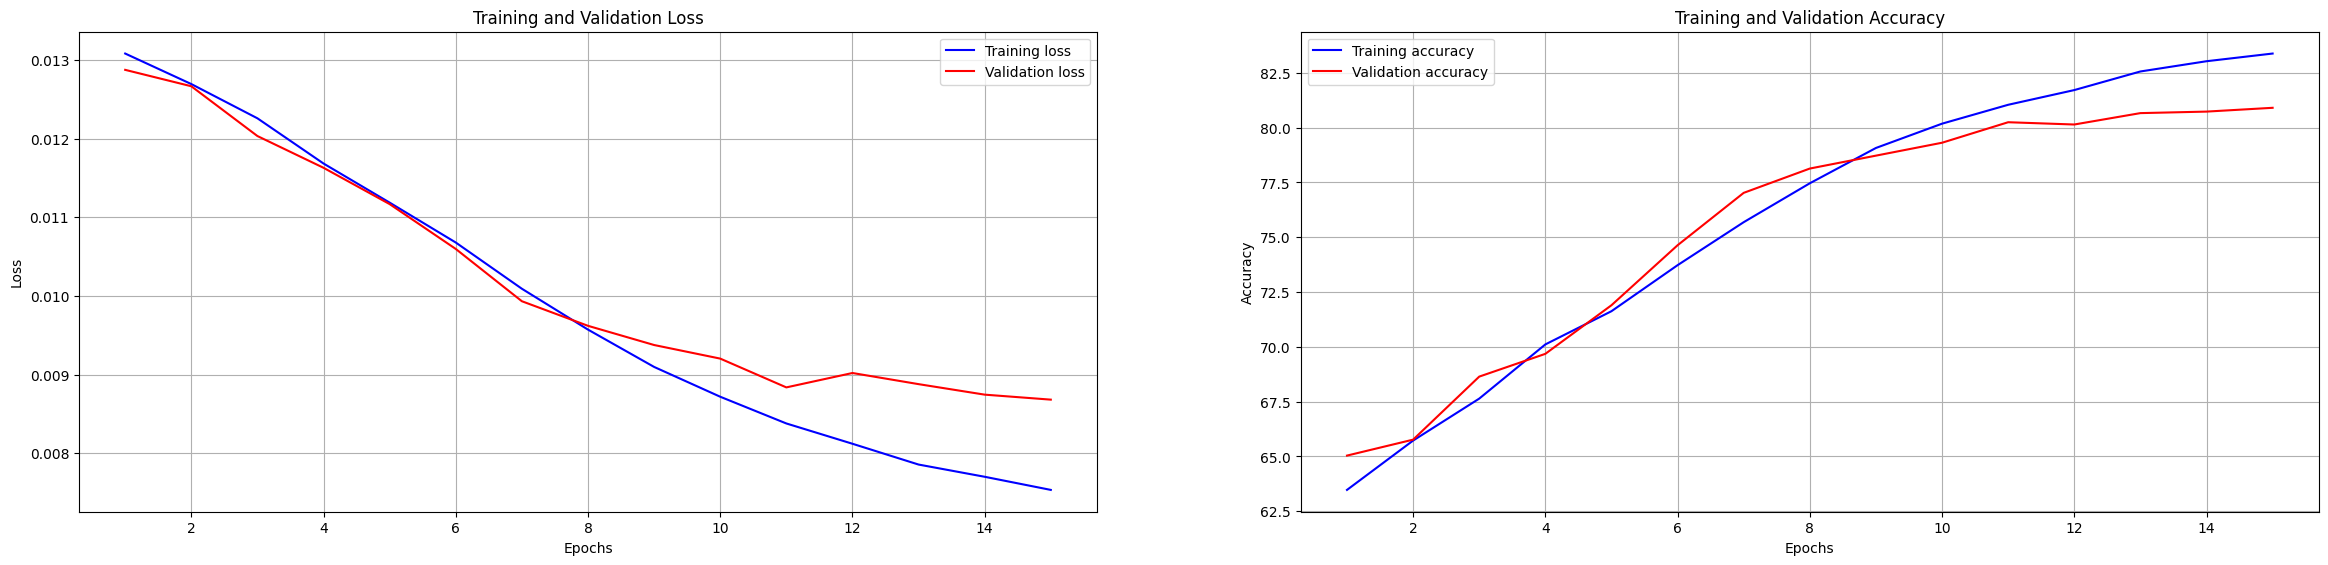

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, len(los_values) + 1)

acc_train= [tensor.item() for tensor in acc_values]
acc_val = [tensor.item() for tensor in val_acc_values]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(left=0.1, right=1.5, bottom=0.1, top=0.9)

axs[0].plot(epochs, los_values, 'b', label='Training loss')
axs[0].plot(epochs, val_los_values, 'r', label='Validation loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(epochs, acc_train, 'b', label='Training accuracy')
axs[1].plot(epochs, acc_val, 'r', label='Validation accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
y_pred = torch.cat(y_predl).cpu().numpy().flatten()
y_true = torch.cat(y_truel).cpu().numpy().flatten()

# Compute precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.8099
Recall: 0.8836
F1 Score: 0.8452
Confusion Matrix:
[[ 791  360]
 [ 202 1534]]


In [ ]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.69, False Positive Rate: 0.12
Class 1 - Precision: 0.80, Recall: 0.69

Class 2 - True Positive Rate: 0.88, False Positive Rate: 0.31
Class 2 - Precision: 0.81, Recall: 0.88



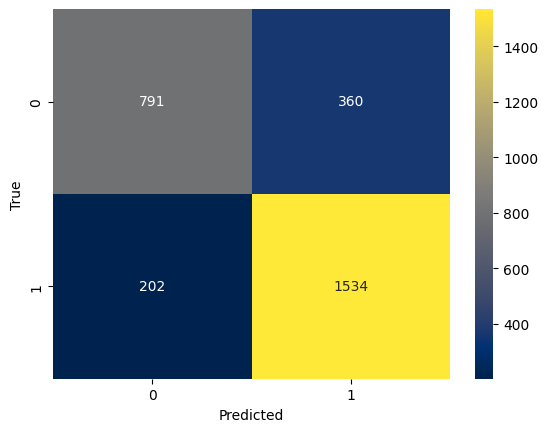

<Figure size 1000x500 with 0 Axes>

In [ ]:
import seaborn as sns
sns.heatmap(con_mat, annot=True, fmt='d', cmap='cividis', cbar=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(10,5))
plt.show()


In [ ]:
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

TransformHelp(
  (embd): Embedding(100000, 74)
  (tra_enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=74, out_features=74, bias=True)
    )
    (linear1): Linear(in_features=74, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=74, bias=True)
    (norm1): LayerNorm((74,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((74,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=74, out_features=74, bias=True)
        )
        (linear1): Linear(in_features=74, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=

0.785434524977279


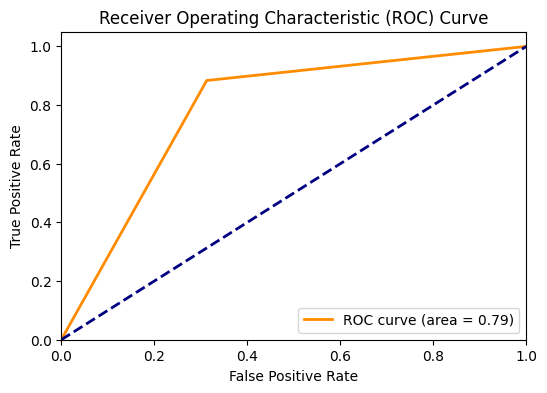

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

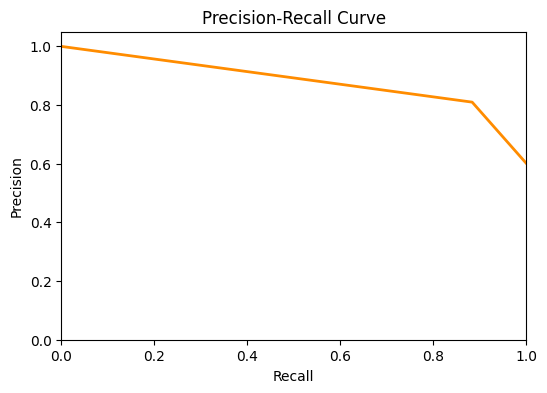

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='darkorange', lw=2)
#plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/transformer.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/transformer.pkl', 'rb') as f:
    model1 = pickle.load(f)

# Transoformer using GLOVE

In [ ]:
import numpy as np
import torch
def gloveEmbeddings(path, embedding_dim=74):
    embeds = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:embedding_dim+1], dtype=np.float32)
            embeds[word] = vector
    return embeds

glove_path = '/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/glove.6B.300d.txt'
glove_embeddings = gloveEmbeddings(glove_path)
vocab = {word: i+1 for i, word in enumerate(glove_embeddings)}
vocab_size = len(vocab) + 1
print(vocab_size)
embedding_dim = 74

def embedding_matrix(glove_embeddings, vocab, embedding_dim):
    embd_matrix = np.zeros((len(vocab)+1, embedding_dim))

    for word, idx in vocab.items():
        embd_matrix[idx] = glove_embeddings.get(word, np.zeros(embedding_dim))

    return torch.tensor(embd_matrix, dtype=torch.float32)

embed_tensor = embedding_matrix(glove_embeddings, vocab, embedding_dim)
print(embed_tensor.shape)

400001
torch.Size([400001, 74])


In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable

def getPositionEncoding(s_len, d_model, n=10000):
    P = np.zeros((s_len, d_model))
    for k in range(s_len):
        for i in np.arange(int(d_model/2)):
            denominator = np.power(n, 2*i/d_model)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return torch.from_numpy(P).float()

class TransformHelp(nn.Module):
    def __init__(self, vocab_size, embedding_size, d_model, nhead, hidden_size, num_layers, dropout, glove_embeddings = embed_tensor):
        super(TransformHelp, self).__init__()

        # Adjust embedding_dim to match d_model
        embedding_dim = d_model

        self.embd = nn.Embedding.from_pretrained(glove_embeddings, freeze=False, padding_idx=0)
        self.pos_enc = nn.Parameter(getPositionEncoding(embedding_size, d_model=d_model))
        self.tra_enc_layer = nn.TransformerEncoderLayer(d_model, nhead, hidden_size, dropout)
        self.trans_enc = nn.TransformerEncoder(self.tra_enc_layer, num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embd(x)
        x = x * np.sqrt(self.pos_enc.shape[1])
        x = x + self.pos_enc
        x = self.trans_enc(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [ ]:
vocab_size = 100000
embedding_size = 74
d_model = 74
nhead = 2
hidden_size = 256
num_layers = 6
dropout = 0.1


model1 = TransformHelp(vocab_size, embedding_size, d_model, nhead, hidden_size, num_layers, dropout)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 30030623


In [ ]:
input_tensor = torch.randint(0, 100000, (50, 74))  # Shape: [50, 74]

# Forward pass to get the shapes
output = model1(input_tensor)
print(output.shape)

torch.Size([50, 1])


In [ ]:
model = TransformHelp(vocab_size, embedding_size, d_model, nhead, hidden_size, num_layers, dropout, glove_embeddings=embed_tensor)

# Print the shape of each layer
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

In [ ]:
import torch.optim as optim
from torch.autograd import Variable


model = model1.cuda()

los_values = []
acc_values = []

val_los_values = []
val_acc_values = []

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)



for epoch in range(12):

    running_loss = 0.0
    running_corrects = 0.0
    count = 0
    print(len(train_dataloader))

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data

        # # Pad sequences to the maximum length in the batch
        # max_len = max([len(seq) for seq in inputs])
        # padded_inputs = torch.zeros(len(inputs), max_len).long()

        # for idx, seq in enumerate(inputs):
        #     padded_inputs[idx, :len(seq)] = seq

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = model(inputs)

        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)
        loss = criterion(outputs.float(), labels.float())

        if(i%100 == 0):
          print(i)
          print(loss)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)

        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}, loss: {running_loss / count:.3f}')

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = (running_corrects / len(train_dataloader.dataset))*100
    print(f'Epoch {epoch + 1} completed. Training Loss: {epoch_loss:.3f}, Training Accuracy: {epoch_acc:.3f}')
    los_values.append(epoch_loss)
    acc_values.append(epoch_acc)

    running_loss = 0.0
    running_corrects = 0
    count = 0

    val_corrects = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data

            # Pad sequences to the maximum length in the batch
            # max_len = max([len(seq) for seq in inputs])
            # padded_inputs = torch.zeros(len(inputs), max_len).long()

            # for idx, seq in enumerate(inputs):
            #     padded_inputs[idx, :len(seq)] = seq

            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            labels = labels.view(-1, 1)
            vloss = criterion(outputs.float(), labels.float())

            val_loss +=vloss.item()
            val_corrects += torch.sum(preds == labels.data)

    val_accuracy = (val_corrects / len(val_dataloader.dataset)) * 100
    ep_val_loss = val_loss/len(val_dataloader.dataset)

    print(f'Epoch {epoch + 1} completed. Validation Loss: {ep_val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')
    val_los_values.append(ep_val_loss)
    val_acc_values.append(val_accuracy)

462
0
tensor(0.8504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,    50] accuracy: 0.589, loss: 0.014
[1,   100] accuracy: 0.598, loss: 0.014
100
tensor(0.6671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   150] accuracy: 0.605, loss: 0.013
[1,   200] accuracy: 0.612, loss: 0.013
200
tensor(0.7319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   250] accuracy: 0.620, loss: 0.013
[1,   300] accuracy: 0.625, loss: 0.013
300
tensor(0.5557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   350] accuracy: 0.628, loss: 0.013
[1,   400] accuracy: 0.629, loss: 0.013
400
tensor(0.6744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[1,   450] accuracy: 0.631, loss: 0.013
Epoch 1 completed. Training Loss: 0.013, Training Accuracy: 63.117
Epoch 1 completed. Validation Loss: 0.013, Validation Accuracy: 64.103
462
0
tensor(0.6687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
[2,    50] accuracy: 0.667, loss: 0.013
[2,   10

In [ ]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong
model.eval()
test_corrects = 0
test_total = 0

y_predl = []
y_truel = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        # max_len = max([len(seq) for seq in inputs])
        # padded_inputs = torch.zeros(len(inputs), max_len).long()

        # for idx, seq in enumerate(inputs):
        #     padded_inputs[idx, :len(seq)] = seq

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        labels = labels.view(-1, 1)

        #print(preds)
        #print(labels.data)

        test_corrects += torch.sum(preds == labels.data)
        test_total += len(preds)

        y_predl.append(preds)
        y_truel.append(labels.data)


test_accuracy = (test_corrects / test_total) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 79.18%


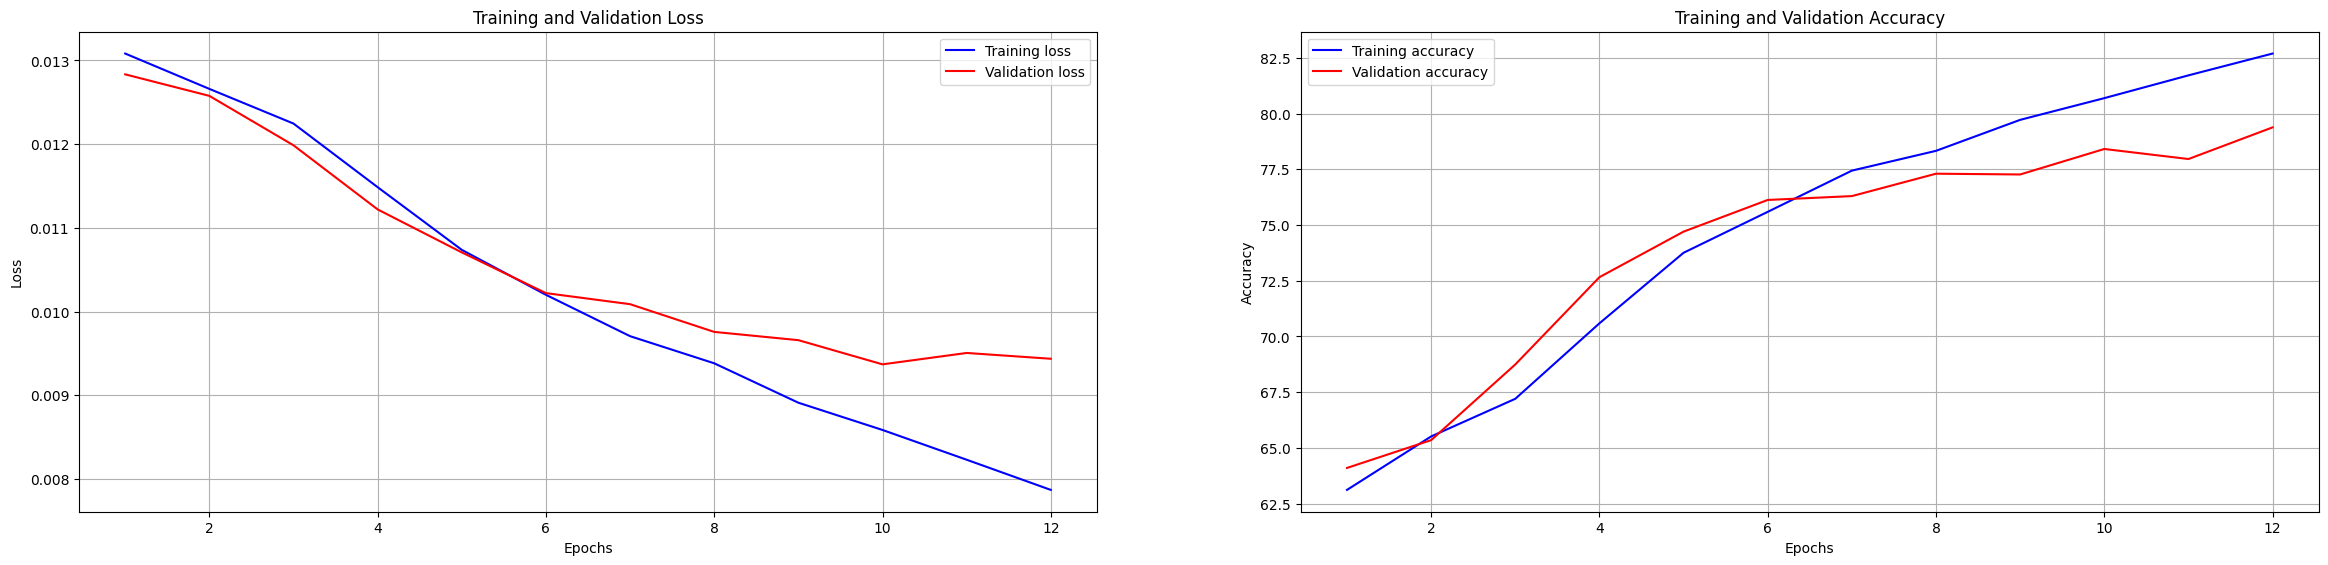

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, len(los_values) + 1)

acc_train= [tensor.item() for tensor in acc_values]
acc_val = [tensor.item() for tensor in val_acc_values]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(left=0.1, right=1.5, bottom=0.1, top=0.9)

axs[0].plot(epochs, los_values, 'b', label='Training loss')
axs[0].plot(epochs, val_los_values, 'r', label='Validation loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(epochs, acc_train, 'b', label='Training accuracy')
axs[1].plot(epochs, acc_val, 'r', label='Validation accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
y_pred = torch.cat(y_predl).cpu().numpy().flatten()
y_true = torch.cat(y_truel).cpu().numpy().flatten()

# Compute precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

Precision: 0.7979
Recall: 0.8756
F1 Score: 0.8349
Confusion Matrix:
[[ 766  385]
 [ 216 1520]]


In [ ]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_true, y_pred)

number_of_classes = con_mat.shape[0]

for i in range(number_of_classes):

    tp = con_mat[i, i]
    fn = np.sum(con_mat[i, :]) - tp
    fp = np.sum(con_mat[:, i]) - tp
    tn = np.sum(con_mat) - (tp + fn + fp)

    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0

    tpr = tp / (tp + fn) if tp + fn != 0 else 0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0

    print(f"Class {i + 1} - True Positive Rate: {tpr:.2f}, False Positive Rate: {fpr:.2f}")
    print(f"Class {i + 1} - Precision: {precision:.2f}, Recall: {recall:.2f}")
    print()

Class 1 - True Positive Rate: 0.67, False Positive Rate: 0.12
Class 1 - Precision: 0.78, Recall: 0.67

Class 2 - True Positive Rate: 0.88, False Positive Rate: 0.33
Class 2 - Precision: 0.80, Recall: 0.88



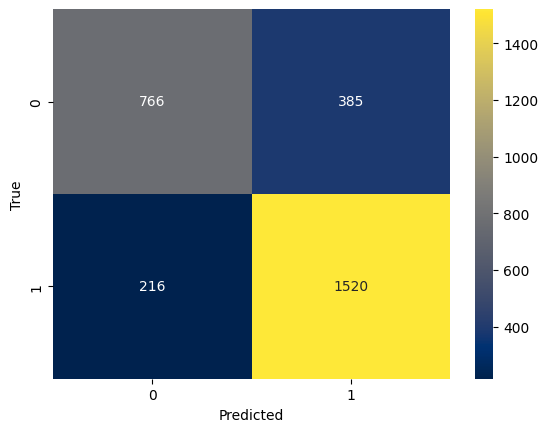

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import seaborn as sns
sns.heatmap(con_mat, annot=True, fmt='d', cmap='cividis', cbar=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.figure(figsize=(20,10))
plt.show()


In [ ]:
print(model)

TransformHelp(
  (embd): Embedding(400001, 74, padding_idx=0)
  (tra_enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=74, out_features=74, bias=True)
    )
    (linear1): Linear(in_features=74, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=74, bias=True)
    (norm1): LayerNorm((74,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((74,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=74, out_features=74, bias=True)
        )
        (linear1): Linear(in_features=74, out_features=256, bias=True)
        (dropout): Dropout(

In [ ]:
import pickle
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/transformer_glove.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('/content/drive/MyDrive/DL_Proj-main/DL_Proj-changes/transformer_glove.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

0.7705421452794005


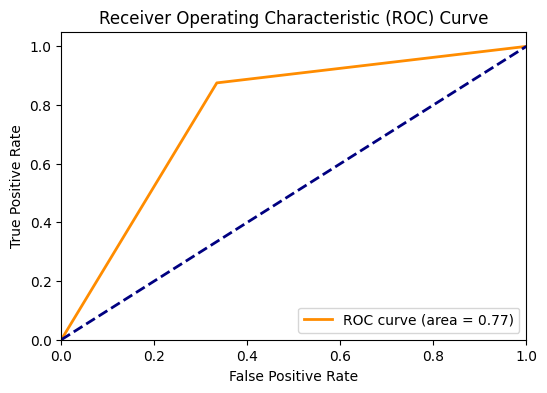

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

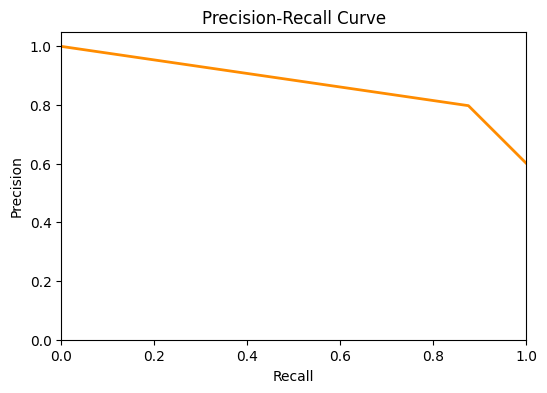

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='darkorange', lw=2)
#plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()